#Part 1

We will use one full day worth of tweets as our input (there are total of 4.4M tweets in this file, but we will intentionally use fewer tweets to run this final):
http://dbgroup.cdm.depaul.edu/DSC450/OneDayOfTweets.txt
Execute and time the following tasks with 110,000 tweets and 550,000 tweets:


a.	Use python to download tweets from the web and save to a local text file (not into a database yet, just to a text file). This is as simple as it sounds, all you need is a for-loop that reads lines from the web and writes them into a file.

NOTE: Do not call read() or readlines(). That command will attempt to read the entire file which is too much data. Clicking on the link in the browser would cause the same problem.


In [ ]:
import time
import requests
import urllib.request
import json
import sqlite3
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [ ]:
url = 'http://dbgroup.cdm.depaul.edu/DSC450/OneDayOfTweets.txt'
count = 0
tweetsnum1 = 110000
start = time.time()

response = requests.get(url, stream=True)
with open("alltweets.txt", "wb") as file:
    for line in response.iter_lines():
        if line:
            encoded_line = line.decode('utf-8') + '\n'
            file.write(encoded_line.encode('utf-8'))
            count += 1
            if count >= tweetsnum1:
                response.close()
                break

end = time.time()
totaltime1a_1 = end - start
print("Total Time - ", totaltime1a_1)

part1a_1 = totaltime1a_1


Total Time -  17.193567514419556


In [ ]:
url = 'http://dbgroup.cdm.depaul.edu/DSC450/OneDayOfTweets.txt'
count = 0
tweetsnum2 = 550000

start = time.time()

response = requests.get(url, stream=True)
with open("alltweets2.txt", "wb") as file:
    for line in response.iter_lines():
        if line:
            encoded_line = line.decode('utf-8') + '\n'
            file.write(encoded_line.encode('utf-8'))
            count += 1
            if count >= tweetsnum2:
                response.close()
                break

end = time.time()
totaltime1a_2 = end - start
print("Total Time - ", totaltime1a_2)

part1a_2 = totaltime1a_2


Total Time -  76.90362167358398


In [ ]:
totaltimepart1a = part1a_1  + part1a_2
print("Total time for part 1 A = ",totaltimepart1a )

Total time for part 1 A =  94.09718918800354


b.	Repeat what you did in part 1-a, but instead of saving tweets to the file, populate the 3-table schema that you previously created in SQLite. Be sure to execute commit and verify that the data has been successfully loaded. Report loaded row counts for each of the 3 tables.

In [ ]:
#Part 1 b (110k tweets)
start = time.time()
numoftweets = 110000
mainurl = 'http://dbgroup.cdm.depaul.edu/DSC450/OneDayOfTweets.txt'
con = sqlite3.connect("Finalpro1.sqlite")
cursor = con.cursor()
cursor.execute('DROP TABLE IF EXISTS tweeter;')
cursor.execute('DROP TABLE IF EXISTS User;')
cursor.execute('DROP TABLE IF EXISTS Geo;')
cursor.execute('''
    CREATE TABLE User (
        id_user INT(100) ,
        name VARCHAR(255),
        screen_name VARCHAR(255),
        description VARCHAR(255),
        friends_count INT(100)
    );
''')

cursor.execute('''
    CREATE TABLE Geo (
        id_geo VARCHAR(255),
        type VARCHAR(255),
        latitude VARCHAR(255),
        longitude VARCHAR(255)
    );
''')

cursor.execute('''
    CREATE TABLE tweeter (
        id VARCHAR(255),
        id_str VARCHAR(255),
        text VARCHAR(255),
        source VARCHAR(255),
        truncated INT(100),
        created_at VARCHAR(255),
        retweet_count INT(100),
        favorite_count INT(100),
        favorited INT(100),
        retweeted INT(100),
        lang VARCHAR(255),
        possibly_sensitive INT(100),
        user_id INT,
        geo_id VARCHAR(255),
        filter_level VARCHAR(255),
        FOREIGN KEY (user_id) REFERENCES User(id_user),
        FOREIGN KEY (geo_id) REFERENCES Geo(id_geo)
    );
''')

try:
    with requests.get(url=mainurl, stream=True) as response:
        if response.status_code == 200:
            count = 0
            numoftweets = 110000
            for line in response.iter_lines():
                all_data = json.loads(line.decode('utf-8'))
                if line:
                    user = all_data['user']
                    if user is not None:
                        sql_user_query = 'INSERT INTO User (id_user, name, screen_name, description, friends_count) VALUES (?, ?, ?, ?, ?);'
                        user_data = (
                            user['id'],
                            user['name'],
                            user['screen_name'],
                            user['description'],
                            user['friends_count']
                        )
                        cursor.execute(sql_user_query, user_data)
                    geo = all_data['geo']

                    if geo is not None:
                        id_geo = str(geo['coordinates'][0]) + "_" + str(geo['coordinates'][1])
                        sql = 'INSERT INTO Geo (id_geo, type, latitude, longitude) VALUES (?, ?, ?, ?);'
                        geo_data = (
                            id_geo,
                            geo['type'],
                            geo['coordinates'][0],
                            geo['coordinates'][1]
                        )
                        cursor.execute(sql, geo_data)
                    else:
                        id_geo = None

                    user_id = all_data['user']['id']
                    sql_tweet_query = 'INSERT INTO tweeter (id, id_str, text, source, truncated, created_at, retweet_count, favorite_count, favorited, retweeted, lang, possibly_sensitive, user_id, geo_id, filter_level) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);'
                    tweet_data = (
                        all_data['id'],
                        all_data['id_str'],
                        all_data['text'],
                        all_data['source'],
                        all_data['truncated'],
                        all_data['created_at'],
                        all_data['retweet_count'],
                        all_data['favorite_count'],
                        all_data['favorited'],
                        all_data['retweeted'],
                        all_data['lang'],
                        all_data['possibly_sensitive'],
                        user_id,
                        id_geo,
                        all_data['filter_level']
                    )
                    cursor.execute(sql_tweet_query, tweet_data)
                    count += 1
                    if count >= numoftweets:
                        break

            con.commit()
        else:
            print("Error downloading tweets. Status code:", response.status_code)
except requests.exceptions.RequestException as e:
    print("Error:", e)

end = time.time() - start
part1b_1 = end
print("Execution Time:", end)
total_tweet_count = cursor.execute('SELECT COUNT(*) FROM tweeter;').fetchone()[0]
print("Total number of rows in tweets table:", total_tweet_count)
total_user_count = cursor.execute('SELECT COUNT(*) FROM User;').fetchone()[0]
print("Total number of rows in users table:", total_user_count)
total_geo_count = cursor.execute('SELECT COUNT(*) FROM Geo;').fetchone()[0]
print("Total number of rows in geo table:", total_geo_count)


Execution Time: 16.954856872558594
Total number of rows in tweets table: 110000
Total number of rows in users table: 110000
Total number of rows in geo table: 2466


In [ ]:
cursor.execute('PRAGMA foreign_key_check(Geo);')
result = cursor.fetchall()
print(result)


[]


In [ ]:
#just checking the data
#cursor.execute('SELECT *  FROM tweeter;')
#geo_data = cursor.fetchall()
#for row in geo_data:
    #print(row)


In [ ]:
#Part 1 b (550k tweets)
start = time.time()
numoftweets = 550000
mainurl = 'http://dbgroup.cdm.depaul.edu/DSC450/OneDayOfTweets.txt'
con = sqlite3.connect("Finalpro2.sqlite")
cursor = con.cursor()
cursor.execute('DROP TABLE IF EXISTS tweeter;')
cursor.execute('DROP TABLE IF EXISTS User;')
cursor.execute('DROP TABLE IF EXISTS Geo;')
cursor.execute('''
    CREATE TABLE User (
        id_user INT(100) ,
        name VARCHAR(255),
        screen_name VARCHAR(255),
        description VARCHAR(255),
        friends_count INT(100)
    );
''')

cursor.execute('''
    CREATE TABLE Geo (
        id_geo VARCHAR(255),
        type VARCHAR(255),
        latitude VARCHAR(255),
        longitude VARCHAR(255)
    );
''')

cursor.execute('''
    CREATE TABLE tweeter (
        id VARCHAR(255),
        id_str VARCHAR(255),
        text VARCHAR(255),
        source VARCHAR(255),
        truncated INT(100),
        created_at VARCHAR(255),
        retweet_count INT(100),
        favorite_count INT(100),
        favorited INT(100),
        retweeted INT(100),
        lang VARCHAR(255),
        possibly_sensitive INT(100),
        user_id INT,
        geo_id VARCHAR(255),
        filter_level VARCHAR(255),
        FOREIGN KEY (user_id) REFERENCES User(id_user),
        FOREIGN KEY (geo_id) REFERENCES Geo(id_geo)
    );
''')

try:
    with requests.get(url=mainurl, stream=True) as response:
        if response.status_code == 200:
            count = 0
            numoftweets = 550000
            for line in response.iter_lines():
                all_data = json.loads(line.decode('utf-8'))
                if line:
                    user = all_data['user']
                    if user is not None:
                        sql_user_query = 'INSERT INTO User (id_user, name, screen_name, description, friends_count) VALUES (?, ?, ?, ?, ?);'
                        user_data = (
                            user['id'],
                            user['name'],
                            user['screen_name'],
                            user['description'],
                            user['friends_count']
                        )
                        cursor.execute(sql_user_query, user_data)
                    geo = all_data['geo']

                    if geo is not None:
                        id_geo = str(geo['coordinates'][0]) + "_" + str(geo['coordinates'][1])
                        sql = 'INSERT INTO Geo (id_geo, type, latitude, longitude) VALUES (?, ?, ?, ?);'
                        geo_data = (
                            id_geo,
                            geo['type'],
                            geo['coordinates'][0],
                            geo['coordinates'][1]
                        )
                        cursor.execute(sql, geo_data)
                    else:
                        id_geo = None

                    user_id = all_data['user']['id']
                    sql_tweet_query = 'INSERT INTO tweeter (id, id_str, text, source, truncated, created_at, retweet_count, favorite_count, favorited, retweeted, lang, possibly_sensitive, user_id, geo_id, filter_level) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);'
                    tweet_data = (
                        all_data['id'],
                        all_data['id_str'],
                        all_data['text'],
                        all_data['source'],
                        all_data['truncated'],
                        all_data['created_at'],
                        all_data['retweet_count'],
                        all_data['favorite_count'],
                        all_data['favorited'],
                        all_data['retweeted'],
                        all_data['lang'],
                        all_data['possibly_sensitive'],
                        user_id,
                        id_geo,
                        all_data['filter_level']
                    )
                    cursor.execute(sql_tweet_query, tweet_data)
                    count += 1
                    if count >= numoftweets:
                        break

            con.commit()
        else:
            print("Error downloading tweets. Status code:", response.status_code)
except requests.exceptions.RequestException as e:
    print("Error:", e)

end = time.time() - start
part1b_2 = end
print("Execution Time:", end)
total_tweet_count = cursor.execute('SELECT COUNT(*) FROM tweeter;').fetchone()[0]
print("Total number of rows in tweets table:", total_tweet_count)
total_user_count = cursor.execute('SELECT COUNT(*) FROM User;').fetchone()[0]
print("Total number of rows in users table:", total_user_count)
total_geo_count = cursor.execute('SELECT COUNT(*) FROM Geo;').fetchone()[0]
print("Total number of rows in geo table:", total_geo_count)


Execution Time: 90.86652827262878
Total number of rows in tweets table: 550000
Total number of rows in users table: 550000
Total number of rows in geo table: 13254


In [ ]:
totaltimepart1b = part1b_1  + part1b_2
print("Total time for part 1 B = ",totaltimepart1b )

Total time for part 1 B =  107.82138514518738


c.	Use your locally saved tweet file to repeat the database population step from part-c. That is, load the tweets into the 3-table database using your saved file with tweets. This is the same code as in 1-b, but reading tweets from your file, not from the web.

In [ ]:
#1c
start = time.time()
con = sqlite3.connect("Finalpro1c.sqlite")
cursor = con.cursor()
cursor.execute('DROP TABLE IF EXISTS User;')
cursor.execute('DROP TABLE IF EXISTS tweeter;')
cursor.execute('DROP TABLE IF EXISTS Geo;')
cursor.execute('''
    CREATE TABLE User (
        id INT(100),
        name VARCHAR2(255),
        screen_name VARCHAR2(255),
        description VARCHAR2(255),
        friends_count INT(100)
    );
''')

cursor.execute("""
 CREATE TABLE tweeter (
        id INT(100),
        id_str VARCHAR2(255),
        text VARCHAR2(255),
        source VARCHAR2(255),
        truncated INT(100),
        created_at VARCHAR2(255),
        retweet_count INT(100),
        favorite_count INT(100),
        favorited INT(100),
        retweeted INT(100),
        lang VARCHAR2(255),
        possibly_sensitive INT(100),
        user_id INT,
        geo_id VARCHAR(255),
        filter_level VARCHAR2(255),
        FOREIGN KEY (user_id) REFERENCES User(id),
        FOREIGN KEY (geo_id) REFERENCES Geo(id_geo)
    );
""")
cursor.execute('''
    CREATE TABLE Geo (
        id_geo TEXT ,
        type VARCHAR2(255),
        latitude VARCHAR2(255),
        longitude VARCHAR2(255)
    );
''')
numoftweets = 110000
count = 0
error_count = 0


try:
    with open('/content/alltweets.txt', 'rb') as df:

      for line in df:
            try:
                all_data = json.loads(line.decode('utf-8'))
                user_id = all_data['user']['id']
                id_geo = None
                sql_tweet_query = 'INSERT INTO tweeter (id,id_str,text,source,truncated,created_at,retweet_count,favorite_count,favorited,retweeted, lang, possibly_sensitive,filter_level,user_id,geo_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?,?,?,?);'
                tweet_data = (
                    all_data['id'],
                    all_data['id_str'],
                    all_data['text'],
                    all_data['source'],
                    all_data['truncated'],
                    all_data['created_at'],
                    all_data['retweet_count'],
                    all_data['favorite_count'],
                    all_data['favorited'],
                    all_data['retweeted'],
                    all_data['lang'],
                    all_data['possibly_sensitive'],
                    all_data['filter_level'],
                    user_id,
                    id_geo
                )
                cursor.execute(sql_tweet_query, tweet_data)

                # Insert user
                user = all_data['user']
                if user is not None:
                    sql_user_query = 'INSERT INTO User (id, name, screen_name, description, friends_count) VALUES (?, ?, ?, ?, ?);'
                    user_data = (
                        user['id'],
                        user['name'],
                        user['screen_name'],
                        user['description'],
                        user['friends_count']
                    )
                    cursor.execute(sql_user_query, user_data)

                if geo is not None:
                        id_geo = str(geo['coordinates'][0]) + "_" + str(geo['coordinates'][1])
                        sql = 'INSERT INTO Geo (id_geo, type, latitude, longitude) VALUES (?, ?, ?, ?);'
                        geo_data = (
                            id_geo,
                            geo['type'],
                            geo['coordinates'][0],
                            geo['coordinates'][1]
                        )
                        cursor.execute(sql, geo_data)
                else:
                    id_geo = None

                count += 1
                if count >= numoftweets:
                    break
            except json.JSONDecodeError:
                error_count += 1
                continue
      con.commit()

except FileNotFoundError:
    print("File not found.")

end = time.time() - start
print("Execution Time:", end)
total_tweet_count = cursor.execute('SELECT COUNT(*) FROM tweeter;').fetchone()[0]
print("Total number of rows in tweets table:", total_tweet_count)
total_user_count = cursor.execute('SELECT COUNT(*) FROM User;').fetchone()[0]
print("Total number of rows in users table:", total_user_count)
total_geo_count = cursor.execute('SELECT COUNT(*) FROM Geo;').fetchone()[0]
print("Total number of rows in geo table:", total_geo_count)

part1c_1 = end

Execution Time: 10.711484909057617
Total number of rows in tweets table: 110000
Total number of rows in users table: 110000
Total number of rows in geo table: 0


In [ ]:
#1c
start = time.time()
con = sqlite3.connect("Finalpro1c.sqlite")
cursor = con.cursor()
cursor.execute('DROP TABLE IF EXISTS User;')
cursor.execute('DROP TABLE IF EXISTS tweeter;')
cursor.execute('DROP TABLE IF EXISTS Geo;')
cursor.execute('''
    CREATE TABLE User (
        id INT(100),
        name VARCHAR2(255),
        screen_name VARCHAR2(255),
        description VARCHAR2(255),
        friends_count INT(100)
    );
''')

cursor.execute("""
 CREATE TABLE tweeter (
        id INT(100),
        id_str VARCHAR2(255),
        text VARCHAR2(255),
        source VARCHAR2(255),
        truncated INT(100),
        created_at VARCHAR2(255),
        retweet_count INT(100),
        favorite_count INT(100),
        favorited INT(100),
        retweeted INT(100),
        lang VARCHAR2(255),
        possibly_sensitive INT(100),
        user_id INT,
        geo_id VARCHAR(255),
        filter_level VARCHAR2(255),
        FOREIGN KEY (user_id) REFERENCES User(id),
        FOREIGN KEY (geo_id) REFERENCES Geo(id_geo)
    );
""")
cursor.execute('''
    CREATE TABLE Geo (
        id_geo TEXT ,
        type VARCHAR2(255),
        latitude VARCHAR2(255),
        longitude VARCHAR2(255)
    );
''')
numoftweets = 550000
count = 0
error_count = 0


try:
    with open('/content/alltweets2.txt', 'rb') as df:

      for line in df:
            try:
                all_data = json.loads(line.decode('utf-8'))
                user_id = all_data['user']['id']
                id_geo = None
                sql_tweet_query = 'INSERT INTO tweeter (id,id_str,text,source,truncated,created_at,retweet_count,favorite_count,favorited,retweeted, lang, possibly_sensitive,filter_level,user_id,geo_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?,?,?,?);'
                tweet_data = (
                    all_data['id'],
                    all_data['id_str'],
                    all_data['text'],
                    all_data['source'],
                    all_data['truncated'],
                    all_data['created_at'],
                    all_data['retweet_count'],
                    all_data['favorite_count'],
                    all_data['favorited'],
                    all_data['retweeted'],
                    all_data['lang'],
                    all_data['possibly_sensitive'],
                    all_data['filter_level'],
                    user_id,
                    id_geo
                )
                cursor.execute(sql_tweet_query, tweet_data)

                user = all_data['user']
                if user is not None:
                    sql_user_query = 'INSERT INTO User (id, name, screen_name, description, friends_count) VALUES (?, ?, ?, ?, ?);'
                    user_data = (
                        user['id'],
                        user['name'],
                        user['screen_name'],
                        user['description'],
                        user['friends_count']
                    )
                    cursor.execute(sql_user_query, user_data)

                if geo is not None:
                        id_geo = str(geo['coordinates'][0]) + "_" + str(geo['coordinates'][1])
                        sql = 'INSERT INTO Geo (id_geo, type, latitude, longitude) VALUES (?, ?, ?, ?);'
                        geo_data = (
                            id_geo,
                            geo['type'],
                            geo['coordinates'][0],
                            geo['coordinates'][1]
                        )
                        cursor.execute(sql, geo_data)
                else:
                    id_geo = None

                count += 1
                if count >= numoftweets:
                    break
            except json.JSONDecodeError:
                error_count += 1
                continue
      con.commit()

except FileNotFoundError:
    print("File not found.")

end = time.time() - start
print("Execution Time:", end)
total_tweet_count = cursor.execute('SELECT COUNT(*) FROM tweeter;').fetchone()[0]
print("Total number of rows in tweets table:", total_tweet_count)
total_user_count = cursor.execute('SELECT COUNT(*) FROM User;').fetchone()[0]
print("Total number of rows in users table:", total_user_count)
total_geo_count = cursor.execute('SELECT COUNT(*) FROM Geo;').fetchone()[0]
print("Total number of rows in geo table:", total_geo_count)

part1c_2 = end

Execution Time: 45.86909532546997
Total number of rows in tweets table: 550000
Total number of rows in users table: 550000
Total number of rows in geo table: 0


In [ ]:
totaltimepart1c = part1c_1  + part1c_2
print("Total time for part 1 C = ",totaltimepart1c )


Total time for part 1 C =  56.58058023452759


d. Repeat the same step with a batching size of 2,000 (i.e. by inserting 2,000 rows at a time with executemany instead of doing individual inserts). Since many of the tweets are missing a Geo location, its fine for the batches of Geo inserts to be smaller than 2,000.

In [ ]:
#1d
start = time.time()
con = sqlite3.connect("Finalpro1d.sqlite")
cursor = con.cursor()
cursor.execute('DROP TABLE IF EXISTS User;')
cursor.execute('DROP TABLE IF EXISTS tweeter;')
cursor.execute('DROP TABLE IF EXISTS Geo;')
cursor.execute('''
    CREATE TABLE User (
        id INT(100),
        name VARCHAR2(255),
        screen_name VARCHAR2(255),
        description VARCHAR2(255),
        friends_count INT(100)
    );
''')

cursor.execute("""
 CREATE TABLE tweeter (
        id INT(100),
        id_str VARCHAR2(255),
        text VARCHAR2(255),
        source VARCHAR2(255),
        truncated INT(100),
        created_at VARCHAR2(255),
        retweet_count INT(100),
        favorite_count INT(100),
        favorited INT(100),
        retweeted INT(100),
        lang VARCHAR2(255),
        possibly_sensitive INT(100),
        user_id INT,
        geo_id VARCHAR(255),
        filter_level VARCHAR2(255),
        FOREIGN KEY (user_id) REFERENCES User(id),
        FOREIGN KEY (geo_id) REFERENCES Geo(id_geo)
    );
""")

cursor.execute('''
    CREATE TABLE Geo (
        id_geo VARCHAR2(255),
        type VARCHAR2(255),
        latitude VARCHAR2(255),
        longitude VARCHAR2(255)
    );
''')

numoftweets = 110000
batch_size = 2000
count = 0
error_count = 0

try:
    with open('/content/alltweets.txt', 'rb') as df:
        tweet_data_batch = []
        user_data_batch = []
        geo_data_batch = []
        for line in df:
            try:
                all_data = json.loads(line.decode('utf-8'))

                user_id = all_data['user']['id']
                sql_tweet_query = 'INSERT INTO tweeter (id,id_str,text,source,truncated,created_at,retweet_count,favorite_count,favorited,retweeted, lang, possibly_sensitive,filter_level,user_id,geo_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?,?,?,?);'
                tweet_data = (
                        all_data['id'],
                        all_data['id_str'],
                        all_data['text'],
                        all_data['source'],
                        all_data['truncated'],
                        all_data['created_at'],
                        all_data['retweet_count'],
                        all_data['favorite_count'],
                        all_data['favorited'],
                        all_data['retweeted'],
                        all_data['lang'],
                        all_data['possibly_sensitive'],
                        all_data['filter_level'],
                        user_id,
                        id_geo
                    )
                tweet_data_batch.append(tweet_data)

                user = all_data['user']
                if user is not None:
                    user_data = (
                        user['id'],
                        user['name'],
                        user['screen_name'],
                        user['description'],
                        user['friends_count']
                    )
                    user_data_batch.append(user_data)

                geo = all_data['geo']
                if geo is not None:
                    id_geo = str(geo['coordinates'][0]) + "_" + str(geo['coordinates'][1])
                    geo_data = (
                        id_geo,
                        geo['type'],
                        geo['coordinates'][0],
                        geo['coordinates'][1]
                    )
                    geo_data_batch.append(geo_data)

                count += 1
                if count >= numoftweets:
                    break

                if len(tweet_data_batch) >= batch_size:
                    cursor.executemany('INSERT INTO tweeter VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?)', tweet_data_batch)
                    cursor.executemany('INSERT INTO User VALUES (?, ?, ?, ?, ?)', user_data_batch)
                    cursor.executemany('INSERT INTO Geo VALUES (?, ?, ?, ?)', geo_data_batch)
                    con.commit()
                    print("tweet batch size",len(tweet_data_batch))
                    tweet_data_batch.clear()
                    user_data_batch.clear()
                    geo_data_batch.clear()

            except json.JSONDecodeError:
                error_count += 1
                continue

        if len(tweet_data_batch) > 0:
            cursor.executemany('INSERT INTO tweeter VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?)', tweet_data_batch)
            cursor.executemany('INSERT INTO User VALUES (?, ?, ?, ?, ?)', user_data_batch)
            cursor.executemany('INSERT INTO Geo VALUES (?, ?, ?, ?)', geo_data_batch)
            con.commit()

except FileNotFoundError:
    print("File not found.")

end = time.time() - start
print("Execution Time:", end)
total_tweet_count = cursor.execute('SELECT COUNT(*) FROM tweeter;').fetchone()[0]
print("Total number of rows in tweets table:", total_tweet_count)
total_user_count = cursor.execute('SELECT COUNT(*) FROM User;').fetchone()[0]
print("Total number of rows in users table:", total_user_count)
total_geo_count = cursor.execute('SELECT COUNT(*) FROM Geo;').fetchone()[0]
print("Total number of rows in geo table:", total_geo_count)
print("Total number of JSON decoding errors:", error_count)

part1d_1 = end

tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batch size 2000
tweet batc

In [ ]:
#1d-2
start = time.time()
con = sqlite3.connect("Finalpro1d.sqlite")
cursor = con.cursor()
cursor.execute('DROP TABLE IF EXISTS User;')
cursor.execute('DROP TABLE IF EXISTS tweeter;')
cursor.execute('DROP TABLE IF EXISTS Geo;')
cursor.execute('''
    CREATE TABLE User (
        id INT(100),
        name VARCHAR2(255),
        screen_name VARCHAR2(255),
        description VARCHAR2(255),
        friends_count INT(100)
    );
''')

cursor.execute("""
 CREATE TABLE tweeter (
        id INT(100),
        id_str VARCHAR2(255),
        text VARCHAR2(255),
        source VARCHAR2(255),
        truncated INT(100),
        created_at VARCHAR2(255),
        retweet_count INT(100),
        favorite_count INT(100),
        favorited INT(100),
        retweeted INT(100),
        lang VARCHAR2(255),
        possibly_sensitive INT(100),
        user_id INT,
        geo_id VARCHAR(255),
        filter_level VARCHAR2(255),
        FOREIGN KEY (user_id) REFERENCES User(id),
        FOREIGN KEY (geo_id) REFERENCES Geo(id_geo)
    );
""")

cursor.execute('''
    CREATE TABLE Geo (
        id_geo VARCHAR2(255),
        type VARCHAR2(255),
        latitude VARCHAR2(255),
        longitude VARCHAR2(255)
    );
''')

tweetsnum2 = 550000
batch_size = 2000
count = 0
error_count = 0

try:
    with open('/content/alltweets2.txt', 'rb') as df:
        tweet_data_batch = []
        user_data_batch = []
        geo_data_batch = []
        for line in df:
            try:
                all_data = json.loads(line.decode('utf-8'))
                user_id = all_data['user']['id']
                sql_tweet_query = 'INSERT INTO tweeter (id,id_str,text,source,truncated,created_at,retweet_count,favorite_count,favorited,retweeted, lang, possibly_sensitive,filter_level,user_id,geo_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?,?,?,?);'
                tweet_data = (
                        all_data['id'],
                        all_data['id_str'],
                        all_data['text'],
                        all_data['source'],
                        all_data['truncated'],
                        all_data['created_at'],
                        all_data['retweet_count'],
                        all_data['favorite_count'],
                        all_data['favorited'],
                        all_data['retweeted'],
                        all_data['lang'],
                        all_data['possibly_sensitive'],
                        all_data['filter_level'],
                        user_id,
                        id_geo
                    )
                tweet_data_batch.append(tweet_data)

                user = all_data['user']
                if user is not None:
                    user_data = (
                        user['id'],
                        user['name'],
                        user['screen_name'],
                        user['description'],
                        user['friends_count']
                    )
                    user_data_batch.append(user_data)

                geo = all_data['geo']
                if geo is not None:
                    id_geo = str(geo['coordinates'][0]) + "_" + str(geo['coordinates'][1])
                    geo_data = (
                        id_geo,
                        geo['type'],
                        geo['coordinates'][0],
                        geo['coordinates'][1]
                    )
                    geo_data_batch.append(geo_data)

                count += 1
                if count >= tweetsnum2:
                    break

                if len(tweet_data_batch) >= batch_size:
                    cursor.executemany('INSERT INTO tweeter VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? ,?, ?)', tweet_data_batch)
                    cursor.executemany('INSERT INTO User VALUES (?, ?, ?, ?, ?)', user_data_batch)
                    cursor.executemany('INSERT INTO Geo VALUES (?, ?, ?, ?)', geo_data_batch)
                    con.commit()
                    #print("tweet batch size",len(tweet_data_batch))
                    tweet_data_batch.clear()
                    user_data_batch.clear()
                    geo_data_batch.clear()

            except json.JSONDecodeError:
                error_count += 1
                continue

        if len(tweet_data_batch) > 0:
            cursor.executemany('INSERT INTO tweeter VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?, ?)', tweet_data_batch)
            cursor.executemany('INSERT INTO User VALUES (?, ?, ?, ?, ?)', user_data_batch)
            cursor.executemany('INSERT INTO Geo VALUES (?, ?, ?, ?)', geo_data_batch)
            con.commit()

except FileNotFoundError:
    print("File not found.")

end = time.time() - start
print("Execution Time:", end)
total_tweet_count = cursor.execute('SELECT COUNT(*) FROM tweeter;').fetchone()[0]
print("Total number of rows in tweets table:", total_tweet_count)
total_user_count = cursor.execute('SELECT COUNT(*) FROM User;').fetchone()[0]
print("Total number of rows in users table:", total_user_count)
total_geo_count = cursor.execute('SELECT COUNT(*) FROM Geo;').fetchone()[0]
print("Total number of rows in geo table:", total_geo_count)

part1d_2 = end


Execution Time: 46.816338300704956
Total number of rows in tweets table: 550000
Total number of rows in users table: 550000
Total number of rows in geo table: 13254


In [ ]:
totaltimepart1d = part1d_1 + part1d_2
print("Total time taken by part D",totaltimepart1d)

Total time taken by part D 59.235756635665894


e. Plot the resulting runtimes (# of tweets versus runtimes) using matplotlib for 1-a, 1-b, 1-c, and 1-d. How does the runtime compare?

Text(0.5, 1.0, 'Runtime for Tweets')

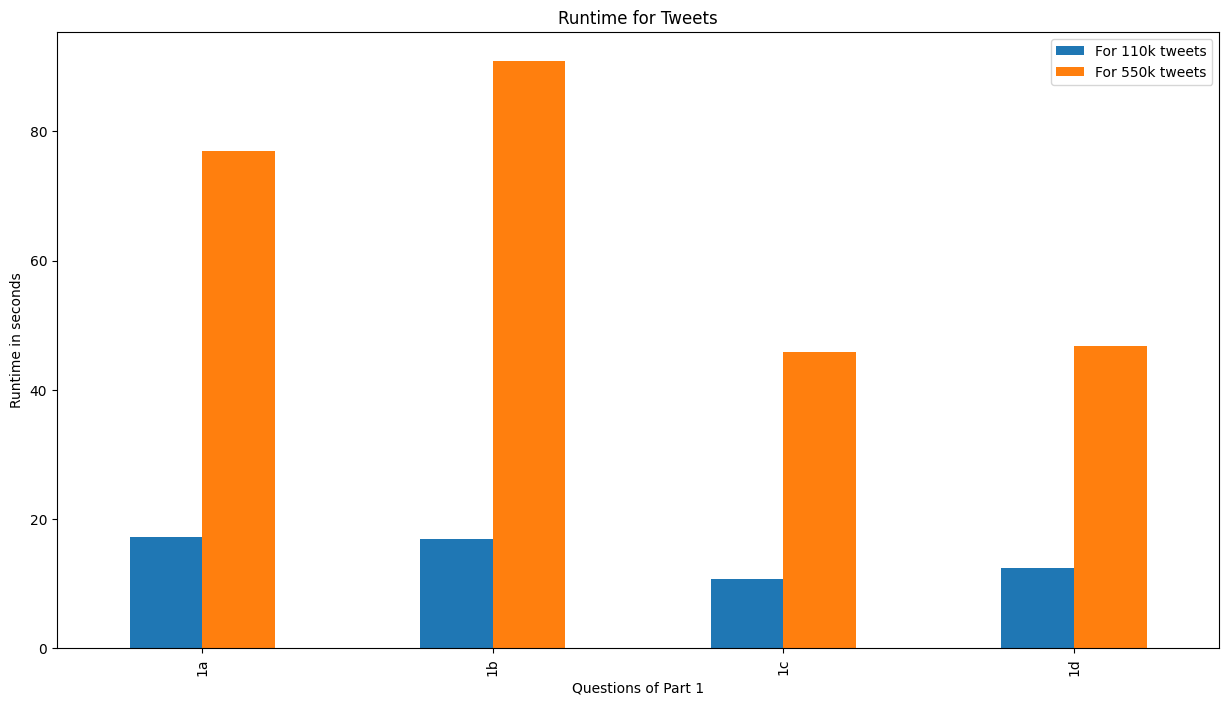

In [ ]:
import pandas as pd

runtimefor110k = [part1a_1,part1b_1,part1c_1,part1d_1]
runtimefor550k = [part1a_2,part1b_2,part1c_2,part1d_2]
plotdata = pd.DataFrame({

    "For 110k tweets":runtimefor110k,

    "For 550k tweets":runtimefor550k},

    index=["1a", "1b", "1c", "1d"])

plotdata.plot(kind="bar",figsize=(15, 8))


plt.xlabel('Questions of Part 1')
plt.ylabel('Runtime in seconds')
plt.title('Runtime for Tweets')



#Part 2

a.	Write and execute a SQL query to find the average longitude and latitude value for each user ID. This query does not need the User table because User ID is a foreign key in the Tweet table. E.g., something like SELECT UserID, MIN(longitude), MAX(latitude) FROM Tweet, Geo WHERE Tweet.GeoFK = Geo.GeoID GROUP BY UserID;

My Foreign key was not working properly so thats why i was checking my constraints properly . but now it's working properly  

In [ ]:
import sqlite3
import pandas as pd

con = sqlite3.connect('Finalpro.sqlite')
cursor = con.cursor()
cursor.execute('PRAGMA foreign_key_check(Geo);')
result = cursor.fetchall()
if len(result) == 0:
    print("Foreign key constraints are satisfied.")
else:
    print("Foreign key constraints are violated.")
    print(result)


start = time.time()
results = []
results = cursor.execute("""
        select tweeter.user_id, avg(Geo.longitude), avg(Geo.latitude)
        from tweeter, Geo
        where tweeter.geo_id = Geo.id_geo group by user_id order by user_id;
""").fetchall()

end = time.time() - start
print("Time taken to retrieve the data:", end)


for row in results[:10]:
    user_id, avg_longitude, avg_latitude = row
    print("User ID:", user_id)
    print("Average Longitude:", avg_longitude)
    print("Average Latitude:", avg_latitude)
    print()


con.close()

Foreign key constraints are satisfied.
Time taken to retrieve the data: 0.25992250442504883
User ID: 7819
Average Longitude: -112.073076
Average Latitude: 33.48155

User ID: 355203
Average Longitude: -73.973056
Average Latitude: 40.6895

User ID: 647853
Average Longitude: -74.034499
Average Latitude: 4.691722

User ID: 970871
Average Longitude: -122.144176
Average Latitude: 37.369168

User ID: 4068821
Average Longitude: -80.366164
Average Latitude: 25.702413

User ID: 4462131
Average Longitude: 139.717688
Average Latitude: 35.671795

User ID: 4781811
Average Longitude: 80.21232
Average Latitude: 13.044448

User ID: 4867131
Average Longitude: 139.699031
Average Latitude: 35.663953

User ID: 5408562
Average Longitude: -78.18603
Average Latitude: 39.160163

User ID: 5526282
Average Longitude: 37.496704
Average Latitude: 55.857744



b.	Re-execute the SQL query in part 2-a 5 times and 20 times and measure the total runtime (just re-run the same exact query multiple times using a for-loop, it is as simple as it looks). Does the runtime scale linearly?

In [ ]:
import sqlite3
import pandas as pd
import time

con = sqlite3.connect('Finalpro.sqlite')
cursor = con.cursor()

num_iterations = [5, 20]
for n in num_iterations:
    start = time.time()
    total_runtime = 0
    for i in range(n):
        start_iteration = time.time()
        results = cursor.execute("""
                SELECT tweeter.user_id, AVG(Geo.longitude), AVG(Geo.latitude)
                FROM tweeter, Geo
                WHERE tweeter.geo_id = Geo.id_geo
                GROUP BY user_id
                ORDER BY user_id;
        """).fetchall()
        end_iteration = time.time() - start_iteration
        total_runtime += end_iteration

    print("Total runtime for {} iterations:".format(n), total_runtime)
    print()

con.close()


Total runtime for 5 iterations: 0.893385648727417

Total runtime for 20 iterations: 3.379757881164551



--> Looks like runtime for number of iterations are increasing in linear way

c.	Write the equivalent of the 2-a query in python (without using SQL) by reading it from the file with 550,000 tweets.

In [ ]:
import json
import pandas as pd
import itertools

data = {}
start = time.time()
with open('/content/alltweets2.txt', 'rb') as file:
    for line in file:
        tweet = json.loads(line.decode('utf-8'))
        user_id = tweet['user']['id']
        if tweet['geo'] is not None:
            coordinates = tweet['geo']['coordinates']
            latitude = coordinates[0]
            longitude = coordinates[1]
            if user_id in data.keys():
                table = data[user_id]
                if tweet['geo']['coordinates'][0] is None:
                    longitude = 0
                    latitude = 0
                table[0] += longitude
                table[1] += latitude
                table[2] += 1
                data[user_id] = table
                pass
            else:
                table = []
                if tweet['geo']['coordinates'][1] is None:
                    latitude = 0
                    longitude = 0
                    pass
                table.append(longitude)
                table.append(latitude)
                table.append(1)
                data[user_id] = table
                pass
            pass
        pass

sorted_dict = dict(itertools.islice(dict(sorted(data.items())).items(), 10))
df = {'user_id': [], 'avg(longitude)': [], 'avg(latitude)': []}
for user_id in sorted_dict:
    table = data[user_id]
    avg_longitude = table[0] / table[2]
    avg_latitude = table[1] / table[2]

    df['user_id'].append(user_id)
    df['avg(longitude)'].append(avg_longitude)
    df['avg(latitude)'].append(avg_latitude)
    pass

df = pd.DataFrame(df)
print(df)
end = time.time() - start
print("Time taken to retrieve the data:", end)

   user_id  avg(longitude)  avg(latitude)
0     7819     -112.073076      33.481550
1   355203      -73.973056      40.689500
2   647853      -74.034499       4.691722
3   970871     -122.144176      37.369168
4  4068821      -80.366164      25.702413
5  4462131      139.717688      35.671795
6  4781811       80.212320      13.044448
7  4867131      139.699031      35.663953
8  5408562      -78.186030      39.160163
9  5526282       37.496704      55.857744
Time taken to retrieve the data: 35.67834258079529


d.	Re-execute the query in part 2-c 5 times and 20 times and measure the total runtime. Does the runtime scale linearly?

In [ ]:
import json
import pandas as pd
import itertools
import time

num_iterations = [5,20]
total_runtime = 0
data = {}
for n in num_iterations:
    start_time = time.time()
    for i in range(n):
      with open('/content/alltweets2.txt', 'rb') as file:
        for line in file:
            tweet = json.loads(line.decode('utf-8'))
            user_id = tweet['user']['id']
            if tweet['geo'] is not None:
                coordinates = tweet['geo']['coordinates']
                latitude = coordinates[0]
                longitude = coordinates[1]
                if user_id in data.keys():
                    table = data[user_id]
                    if tweet['geo']['coordinates'][0] is None:
                        longitude = 0
                        latitude = 0
                    table[0] += longitude
                    table[1] += latitude
                    table[2] += 1
                    data[user_id] = table
                else:
                    table = []
                    if tweet['geo']['coordinates'][1] is None:
                        latitude = 0
                        longitude = 0
                    table.append(longitude)
                    table.append(latitude)
                    table.append(1)
                    data[user_id] = table

        sorted_dict = dict(itertools.islice(dict(sorted(data.items())).items(), 10))
        df = {'user_id': [], 'avg(longitude)': [], 'avg(latitude)': []}
        for user_id in sorted_dict:
            table = data[user_id]
            avg_longitude = table[0] / table[2]
            avg_latitude = table[1] / table[2]

            df['user_id'].append(user_id)
            df['avg(longitude)'].append(avg_longitude)
            df['avg(latitude)'].append(avg_latitude)

        df = pd.DataFrame(df)

        end_time = time.time()
        execution_time = end_time - start_time
        total_runtime += execution_time

    print("Total runtime for {} iterations:".format(n), total_runtime)
    print()

Total runtime for 5 iterations: 538.7009913921356

Total runtime for 20 iterations: 8128.305525302887



--> no it does not looks like runtime for number of iterations are increasing in linear way

e.	Write the equivalent of the 2-a query in python by using regular expressions instead of json.loads(). Do not use json.loads() here. Note that you only need to find userid and geo location (if any) for each tweet, you don’t need to parse the whole thing.

In [ ]:
import re
import pandas as pd

tweet_file = 'alltweets2.txt'
user_data = {}

with open(tweet_file, 'rb') as file:
    tweet_count = 0
    count = 0
    for line in file:
        if tweet_count >= 250_000:
            break
        tweet_count += 1
        tweet = line.decode('utf-8')
        tweet = str(tweet)

        user_id_match = re.search(r'(?<="user":{"id":)\d+', tweet)
        if user_id_match:
            user_id = int(user_id_match.group(0))

            geo_data_match = re.search(r'(?<="geo":)\w+', tweet)
            if geo_data_match and geo_data_match.group(0) == 'null':
                has_geo_data = False
            else:
                has_geo_data = True
                geo_match = re.search(r'"geo":\{(.*?)\}', tweet)
                if geo_match:
                    coordinates_match = re.search(r'\[(.*?)\]', geo_match.group(0))
                    if coordinates_match:
                        coordinates = coordinates_match.group(0).rstrip(']').lstrip('[').split(',')
                        latitude = float(coordinates[0])
                        longitude = float(coordinates[1])
                        if user_id in user_data:
                            user_table = user_data[user_id]
                            if coordinates[0] is None:
                                longitude = 0
                                latitude = 0
                            user_table[0] += longitude
                            user_table[1] += latitude
                            user_table[2] += 1
                        else:
                            user_table = [0, 0, 1]
                            if coordinates[1] is None:
                                latitude = 0
                                longitude = 0
                            user_table[0] = longitude
                            user_table[1] = latitude
                            user_data[user_id] = user_table

sorted_user_data = dict(list(sorted(user_data.items()))[:10])
df = {'user_id': [], 'avg_longitude': [], 'avg_latitude': []}
for user_id, user_table in sorted_user_data.items():
    avg_longitude = user_table[0] / user_table[2]
    avg_latitude = user_table[1] / user_table[2]
    df['user_id'].append(user_id)
    df['avg_longitude'].append(avg_longitude)
    df['avg_latitude'].append(avg_latitude)

df = pd.DataFrame(df)
print(df)


   user_id  avg_longitude  avg_latitude
0     7819    -112.073076     33.481550
1   647853     -74.034499      4.691722
2  4462131     139.717688     35.671795
3  4781811      80.212320     13.044448
4  5526282      37.496704     55.857744
5  6859912     -84.512067     39.103553
6  7054752     -84.550199     33.951923
7  7519912       2.355292     48.828888
8  8445422    -123.082099     44.040457
9  8706722     -43.225287    -22.978287


f.	Re-execute the query in part 2-e 5 times and 20 times and measure the total runtime. Does the runtime scale linearly?

In [ ]:
num_iterations = [5, 20]
total_runtime = 0
data = {}

for n in num_iterations:
    start_time = time.time()

    for i in range(n):
        tweet_file = '/content/alltweets2.txt'
        user_data = {}

        with open(tweet_file, 'rb') as file:
            tweet_count = 0
            count = 0
            for line in file:
                if tweet_count >= 250_000:
                    break
                tweet_count += 1
                tweet = line.decode('utf-8')
                tweet = str(tweet)

                user_id_match = re.search(r'(?<="user":{"id":)\d+', tweet)
                if user_id_match:
                    user_id = int(user_id_match.group(0))

                    geo_data_match = re.search(r'(?<="geo":)\w+', tweet)
                    if geo_data_match and geo_data_match.group(0) == 'null':
                        has_geo_data = False
                    else:
                        has_geo_data = True
                        geo_match = re.search(r'"geo":\{(.*?)\}', tweet)
                        if geo_match:
                            coordinates_match = re.search(r'\[(.*?)\]', geo_match.group(0))
                            if coordinates_match:
                                coordinates = coordinates_match.group(0).rstrip(']').lstrip('[').split(',')
                                latitude = float(coordinates[0])
                                longitude = float(coordinates[1])
                                if user_id in user_data:
                                    user_table = user_data[user_id]
                                    if coordinates[0] is None:
                                        longitude = 0
                                        latitude = 0
                                    user_table[0] += longitude
                                    user_table[1] += latitude
                                    user_table[2] += 1
                                else:
                                    user_table = [0, 0, 1]
                                    if coordinates[1] is None:
                                        latitude = 0
                                        longitude = 0
                                    user_table[0] = longitude
                                    user_table[1] = latitude
                                    user_data[user_id] = user_table

        sorted_user_data = dict(list(sorted(user_data.items()))[:10])
        df = {'user_id': [], 'avg_longitude': [], 'avg_latitude': []}
        for user_id, user_table in sorted_user_data.items():
            avg_longitude = user_table[0] / user_table[2]
            avg_latitude = user_table[1] / user_table[2]
            df['user_id'].append(user_id)
            df['avg_longitude'].append(avg_longitude)
            df['avg_latitude'].append(avg_latitude)

        df = pd.DataFrame(df)
        #print(df) not printing the output

    end_time = time.time()
    execution_time = end_time - start_time
    total_runtime += execution_time
    data[n] = execution_time

    print(f"Total runtime for {n} iterations: {execution_time} seconds")
    print()

print(f"Total runtime for all iterations: {total_runtime} seconds")
print("Runtimes for individual iterations:", data)


Total runtime for 5 iterations: 74.5090401172638 seconds

Total runtime for 20 iterations: 299.8694312572479 seconds

Total runtime for all iterations: 374.3784713745117 seconds
Runtimes for individual iterations: {5: 74.5090401172638, 20: 299.8694312572479}


---> Looks like runtime for number of iterations are increasing in linear way

#Part 3

a.	Using the database with 550,000 tweets, create a new table that corresponds to the join of all 3 tables in your database, including records without a geo location. This is the equivalent of a materialized view but since SQLite does not support MVs, we will use CREATE TABLE AS SELECT (instead of CREATE MATERIALIZED VIEW AS SELECT).

In [ ]:
import sqlite3

conn = sqlite3.connect('Finalpro2.sqlite')
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS All_Table_Join")

cursor.execute("""
    CREATE TABLE All_Table_Join AS
    SELECT
        tweeter.*, User.*, Geo.*
    FROM
        tweeter
    LEFT JOIN
        User ON tweeter.user_id = User.id_user
    LEFT JOIN
        Geo ON tweeter.geo_id = Geo.id_geo
""")

cursor.execute('SELECT * FROM All_Table_Join')
all_table_join = cursor.fetchall()
for row in all_table_join[:20]:
    print(row)

conn.close()


('471803285746495500', '471803285746495489', 'There is no wealth but life. ~John Ruskin #wisdomink', '<a href="http://www.hootsuite.com" rel="nofollow">HootSuite</a>', 0, 'Thu May 29 00:00:43 +0000 2014', 0, 0, 0, 0, 'en', 0, 213646047, None, 'medium', 213646047, 'Wisdom Ink', 'Wisdom_Ink', 'Wisdom Ink Online Magazine:  Expressing our #joy & #love via our articles. Celebrating diversity & the growth of #consciousness. #zen #meditation #spiritual', 4821, None, None, None, None)
('471803285738106900', '471803285738106880', 'Mucho la Plop esto, la Plop aquello, pero de los viernes es la fiesta con la gente más linda. \nEn las otras vienen directo de la frontera.', 'web', 0, 'Thu May 29 00:00:43 +0000 2014', 0, 0, 0, 0, 'es', 0, 38950479, None, 'medium', 38950479, 'Yarer Sofier', 'firekites', 'Visite nuestro stand en la planta cuarta. Gran liquidación en revólveres, cuchillos y todos los complementos de la mujer inquieta.', 99, None, None, None, None)
('471803285767462900', '47180328576746

b.	Export the contents of 1) the Tweet table and 2) your new table from 3-a into a new JSON file (i.e., create your own JSON file with just the keys you extracted). You do not need to replicate the structure of the input and can come up with any reasonable keys for each field stored in JSON structure (e.g., you can have longitude as “longitude” key when the location is available).
How do the file sizes compare to the original input file?


In [ ]:
conn = sqlite3.connect("Finalpro2.sqlite")
cursor = conn.cursor()
cursor.execute("SELECT * FROM tweeter")
tweet_data = cursor.fetchall()
cursor.execute("SELECT * FROM All_Table_Join")
all_table_join_data = cursor.fetchall()
tweet_keys = ["id", "id_str", "text", "source", "truncated", "created_at", "retweet_count", "favorite_count", "favorited", "retweeted", "lang", "possibly_sensitive", "user_id", "geo_id", "filter_level"]
all_table_join_keys = ["tweet_id", "tweet_id_str", "tweet_text", "tweet_source", "tweet_truncated", "tweet_created_at", "tweet_retweet_count", "tweet_favorite_count", "tweet_favorited", "tweet_retweeted", "tweet_lang", "tweet_possibly_sensitive", "user_id", "geo_id", "filter_level", "user_id_user", "user_name", "user_screen_name", "user_description", "user_friends_count", "geo_id_geo", "geo_type", "geo_latitude", "geo_longitude"]

combined_data = {
    "tweet_data": [dict(zip(tweet_keys, tweet)) for tweet in tweet_data],
    "all_table_join_data": [dict(zip(all_table_join_keys, row)) for row in all_table_join_data]
}

with open("combined_data.json", "w") as json_file:
    json.dump(combined_data, json_file)




checking the files sizes here

In [ ]:
#
import os
file_path = '/content/alltweets2.txt'
file_path2 = '/content/combined_data.json'
file_size1 = os.path.getsize(file_path)
file_size2 = os.path.getsize(file_path2)
def convert_size(size):
    # 2**10 = 1024
    power = 2 ** 10
    n = 0
    power_labels = {0: 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /= power
        n += 1
    return f"{round(size, 2)} {power_labels[n]}"

file_size_readable1 = convert_size(file_size1)
print(f"The file size of txt file is: {file_size_readable1}")

file_size_readable2 = convert_size(file_size2)
print(f"The file size of Json file is: {file_size_readable2}")

The file size of txt file is: 1.62 GB
The file size of Json file is: 907.38 MB


Json file is way much lighter than Txt file

c.	Export the contents of 1) the Tweet table and 2) your table from 3-a into a .csv (comma separated value) file.
How do the file size compare to the original input file and to the files in 3-b?


In [ ]:
import csv
conn = sqlite3.connect("Finalpro2.sqlite")
cursor = conn.cursor()

cursor.execute("SELECT * FROM tweeter")
tweet_data = cursor.fetchall()

cursor.execute("SELECT * FROM All_Table_Join")
all_table_join_data = cursor.fetchall()

csv_file = "combined_data.csv"

tweet_headers = ["id", "id_str", "text", "source", "truncated", "created_at", "retweet_count", "favorite_count", "favorited", "retweeted", "lang", "possibly_sensitive", "user_id", "geo_id", "filter_level"]
all_table_join_headers = ["tweet_id", "tweet_id_str", "tweet_text", "tweet_source", "tweet_truncated", "tweet_created_at", "tweet_retweet_count", "tweet_favorite_count", "tweet_favorited", "tweet_retweeted", "tweet_lang", "tweet_possibly_sensitive", "user_id", "geo_id", "filter_level", "user_id_user", "user_name", "user_screen_name", "user_description", "user_friends_count", "geo_id_geo", "geo_type", "geo_latitude", "geo_longitude"]

with open(csv_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file, quoting=csv.QUOTE_ALL, escapechar="\"")
    writer.writerow(tweet_headers)
    writer.writerows(tweet_data)
    writer.writerow(all_table_join_headers)
    writer.writerows(all_table_join_data)
conn.close()


Checking the files size over here

In [ ]:
import os
file_path = '/content/alltweets2.txt'
file_path2 = '/content/combined_data.json'
file_path3 = '/content/combined_data.csv'
file_size1 = os.path.getsize(file_path)
file_size2 = os.path.getsize(file_path2)
file_size3 = os.path.getsize(file_path3)
def convert_size(size):
    # 2**10 = 1024
    power = 2 ** 10
    n = 0
    power_labels = {0: 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /= power
        n += 1
    return f"{round(size, 2)} {power_labels[n]}"

file_size_readable1 = convert_size(file_size1)
print(f"The file size of txt file is: {file_size_readable1}")

file_size_readable2 = convert_size(file_size2)
print(f"The file size of Json file is: {file_size_readable2}")

file_size_readable3 = convert_size(file_size3)
print(f"The file size of csv file is: {file_size_readable3}")

The file size of txt file is: 1.62 GB
The file size of Json file is: 907.38 MB
The file size of csv file is: 447.19 MB


CSV files looks 1/4 of the Txt file and CSV files looks 1/2 of the Json file

#coverting file to html

In [ ]:
%%shell
jupyter nbconvert --to html //content/final_database_project.ipynb

[NbConvertApp] Converting notebook //content/final_database_project.ipynb to html
[NbConvertApp] Writing 834257 bytes to //content/final_database_project.html
